# Demo for how to track a capillary (estimate radius and center position) with fluorescently-labeled plasma

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sl2pm import track_vessel
from sl2pm.models import L_plasma_no_glx
from sl2pm import misc

# Calibrating the microscope's PSF

Load kynogram

In [2]:
kymogram = np.load('plasma_kymogram_long.npy')

Plot the kymogram and find a segment without RBCs

Text(0, 0.5, 'x (pix)')

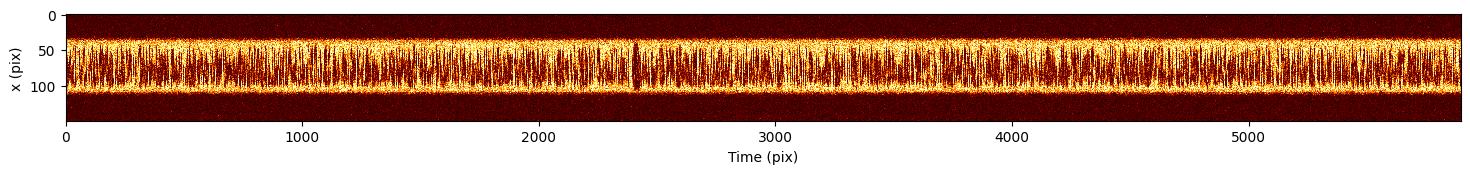

In [3]:
fig, ax = plt.subplots(figsize=(18, 3))

ax.imshow(kymogram.T, 
           cmap='afmhot', 
           vmin=kymogram.min(),
           vmax=0.2*kymogram.max(), # manually selected maximum intensity for better visualization
           aspect=3,
          interpolation='none'
         )

ax.set_xlabel('Time (pix)')
ax.set_ylabel('x (pix)')

Roughly zoom-in into a potential RBC-free segment

Text(0, 0.5, 'x (pix)')

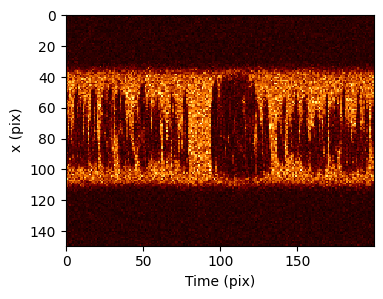

In [4]:
kymogram_no_rbc0 = kymogram[2300: 2500]

fig, ax = plt.subplots(figsize=(18, 3))

ax.imshow(kymogram_no_rbc0.T, 
           cmap='afmhot', 
           vmin=kymogram_no_rbc0.min(),
           vmax=kymogram_no_rbc0.max(),
           aspect=1,
          interpolation='none'
         )

ax.set_xlabel('Time (pix)')
ax.set_ylabel('x (pix)')

Select the RBC-free segment

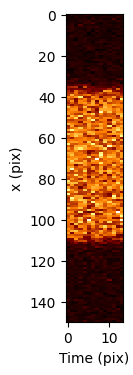

In [5]:
kymogram_no_rbc = kymogram_no_rbc0[80: 94] # Vary the indexes to make sure you are not including RBC shadows into the RBC-free kymogram

fig, ax = plt.subplots(figsize=(6, 4))

ax.imshow(kymogram_no_rbc.T, 
           cmap='afmhot', 
           vmin=kymogram_no_rbc.min(),
           vmax=kymogram_no_rbc.max(),
           aspect=0.5,
          interpolation='none'
         )

ax.set_xlabel('Time (pix)')
ax.set_ylabel('x (pix)')

N_AVER, nx = kymogram_no_rbc.shape
x = np.arange(nx)

Average all line-scans in time

In [6]:
kymogram_no_rbc_mean = kymogram_no_rbc.mean(axis=0) 

N_AVER, nx = kymogram_no_rbc.shape

x = np.arange(nx)

Enter PMT parameters (known from the calibration)

In [7]:
ALPHA = 0.452
SIGMA = 6.0
GAIN = 3/ALPHA

Make an initial parameter guess

In [8]:
p0_B = track_vessel.ols_plasma(kymogram_no_rbc_mean/GAIN, sigma_blur=1.5)

Plot data (red staircase curve – plasma fluorescence) and its expected value (black), evaluated with the initial parameter guess

Text(0, 0.5, 'Photon count')

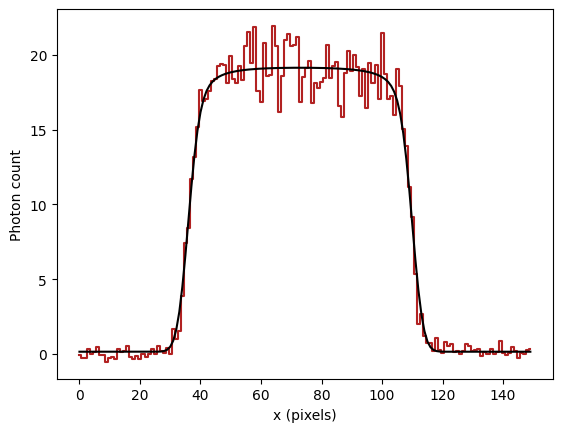

In [9]:
plt.step(x, kymogram_no_rbc_mean/GAIN, where='mid', c='firebrick')
plt.plot(x, L_plasma_no_glx(x, *p0_B), c='k')

plt.xlabel('x (pixels)')
plt.ylabel('Photon count')

Fit model

In [10]:
opt_res_B = track_vessel.mle(x,
                             kymogram_no_rbc_mean,
                             L_plasma_no_glx,
                             p0_B,
                             N_AVER, 
                             ALPHA, 
                             SIGMA, 
                             minimize_options=dict(gtol=1e-3))
opt_res_B

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 575.8926283948226
        x: [ 7.290e+01  2.367e+00  7.748e+00  3.770e+01  1.931e+01
             1.691e-01]
      nit: 10
      jac: [ 3.052e-05  8.392e-05  1.526e-05  0.000e+00 -1.068e-04
             2.289e-05]
 hess_inv: [[ 2.462e-03  5.005e-04 ... -3.202e-04 -2.968e-05]
            [ 5.005e-04  1.285e-02 ... -8.598e-03 -8.370e-04]
            ...
            [-3.202e-04 -8.598e-03 ...  2.220e-02  4.150e-04]
            [-2.968e-05 -8.370e-04 ...  4.150e-04  9.986e-04]]
     nfev: 112
     njev: 16

Plot data (red staircase curves – plasma fluorescence) and its fitted expected value (black)

Text(0, 0.5, 'Photon count')

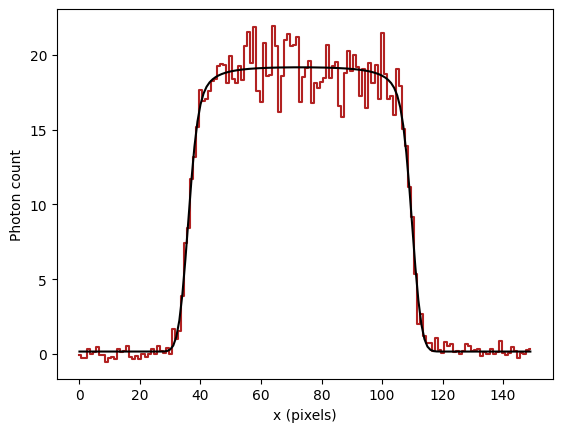

In [11]:
plt.step(x, kymogram_no_rbc_mean/GAIN, where='mid', c='firebrick')
plt.plot(x, L_plasma_no_glx(x, *opt_res_B.x), c='k')

plt.xlabel('x (pixels)')
plt.ylabel('Photon count')

List fitted parameters and their error bars

In [12]:
misc.fitted_params(opt_res_B, ['xc', 's_xy', 'l', 'R_lum', 'I', 'b'])

{'xc': (72.90419878505179, 0.04961733712623755),
 's_xy': (2.3667182988004907, 0.11336192033266987),
 'l': (7.748388526004652, 0.7331129142842018),
 'R_lum': (37.699426035699766, 0.13016779464152703),
 'I': (19.306783395996153, 0.14900262875738188),
 'b': (0.16913187298254534, 0.03160084483725883)}

***

# Preparing fluorescence line-profiles for fitting 

Block-average kymogram (10 line-scans per block) to reduce noise, yielding line-profiles of fluorescence

In [13]:
n_block = 10

kymogram_blocked = kymogram[:-(kymogram.shape[0]%n_block), :].reshape((kymogram.shape[0]//n_block, n_block, nx))
kymogram_blocked_mean = kymogram_blocked.mean(axis=1)

Plot block-averaged kymogram

Text(0, 0.5, 'x (pix)')

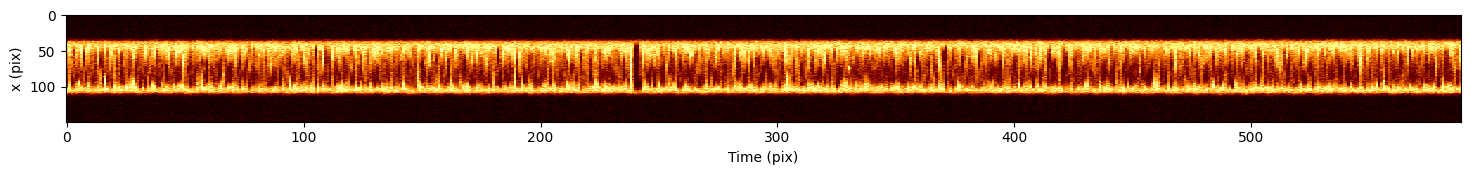

In [14]:
fig, ax = plt.subplots(figsize=(18, 3))

ax.imshow(kymogram_blocked_mean.T, 
           cmap='afmhot', 
           vmin=kymogram_blocked_mean.min(),
           vmax=kymogram_blocked_mean.max(), 
           aspect=0.3,
           interpolation='none'
         )

ax.set_xlabel('Time (pix)')
ax.set_ylabel('x (pix)')

Removing parts of the fluorescence profiles affected by RBCs. We can use estimated center position and capillary radius from the calibration to calculate positions of the edges of the plasma cylinder

In [15]:
edge1, edge2 = opt_res_B.x[0] - opt_res_B.x[3], opt_res_B.x[0] + opt_res_B.x[3]

Text(0, 0.5, 'x (pix)')

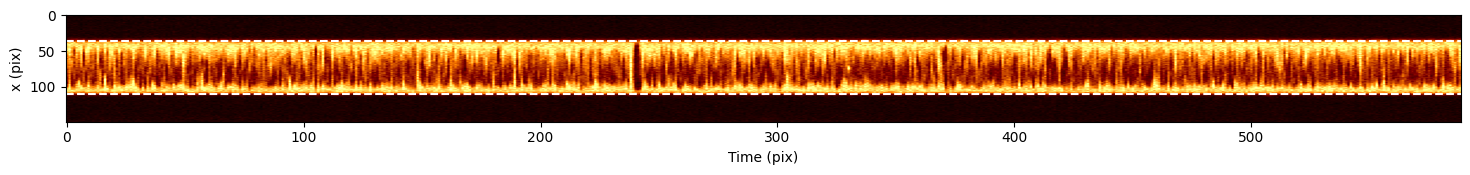

In [16]:
fig, ax = plt.subplots(figsize=(18, 3))

ax.imshow(kymogram_blocked_mean.T, 
           cmap='afmhot', 
           vmin=kymogram_blocked_mean.min(),
           vmax=kymogram_blocked_mean.max(), 
           aspect=0.3,
         )

ax.axhline(y=edge1, ls='--', color='w')
ax.axhline(y=edge2, ls='--', color='w')

ax.set_xlabel('Time (pix)')
ax.set_ylabel('x (pix)')

We want to extract fluorescence only near the edges of the capillary, where the fluorescence is not affected by RBCs

In [17]:
x_index_edge1, x_index_edge2 = np.searchsorted(x, [edge1, edge2])

In [18]:
x_edge1 = x[:x_index_edge1]
y_edge1 = kymogram_blocked_mean[:, :x_index_edge1]

x_edge2 = x[x_index_edge2:]
y_edge2 = kymogram_blocked_mean[:, x_index_edge2:]

Show extracted tails of fluorescence  at three time points (beginning, middle, ending)

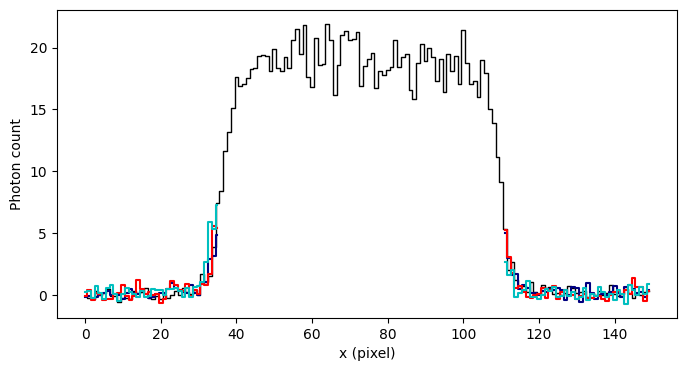

In [19]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.set_xlabel('x (pixel)')
ax.set_ylabel('Photon count')

ax.step(x, kymogram_no_rbc_mean/GAIN, where='mid', c='k', lw=1)

t_indexes = [0, 300, -1]
colors = ['navy', 'r', 'c']

for ti, ci in zip(t_indexes, colors):
    ax.step(x_edge1, y_edge1[ti]/GAIN, where='mid', c=ci) 
    ax.step(x_edge2, y_edge2[ti]/GAIN, where='mid', c=ci) 

***

# Tracking the capillary's center and radius by fitting line-profiles of fluorescence

Function describing the fluoresence intensity on the line profiles, L_plasma_no_glx, has six parameters: $x_c$, $\sigma_{xy}$, $\lambda$, $R_{lum}$, $I$, $b$. We set $\sigma_{xy}$, $\lambda$, $I$, and $b$ to the values obtained from the calibration and only fit $x_c$ and $R_{lum}$ for each line-profile of fluorescence. This new function, depending only on $x_c$ and $R_{lum}$, is denoted L_fit below.

In [20]:
fixed_args = {name: p_calib[name][0] for name in ['s_xy', 'l', 'I', 'b']}

L_fit = lambda x, xc, R_lum: L_plasma_no_glx(x, xc, p_calib['s_xy'][0], p_calib['l'][0], R_lum, p_calib['I'][0], p_calib['b'][0])

Concatenate the line-profiles

In [21]:
x_no_rbc = np.hstack([x_edge1, x_edge2])
y_no_rbc = np.hstack([y_edge1, y_edge2])

Fit all line-profiles

In [22]:
result = [] # contains fitted parameters for each line-profile

for i, y_i in enumerate(y_no_rbc, start=1):

    opt_res_i = track_vessel.mle(x_no_rbc,
                                 y_i,
                                 L_fit,
                                 [p_calib['xc'][0], p_calib['R_lum'][0]], # initial guess from the calibration parameters
                                 n_block, 
                                 ALPHA, 
                                 SIGMA, 
                                 minimize_options=dict(gtol=1e-3))

    result.append(misc.fitted_params(opt_res_i, ['xc', 'R_lum']))

    if i%50 == 0:
        print(f'{i}/{y_no_rbc.shape[0]} fits completed')

50/589 fits completed


/home/jovyan/work/sl2pm/sl2pm/examples/capillaries/../../sl2pm/models.py:68: RuntimeWarning: invalid value encountered in sqrt
  integrand = gaussian(R - X_PSF, s_xy)*(1 - np.exp(-np.sqrt(R_lum**2 - R**2)/l))


100/589 fits completed
150/589 fits completed
200/589 fits completed
250/589 fits completed
300/589 fits completed
350/589 fits completed
400/589 fits completed
450/589 fits completed
500/589 fits completed
550/589 fits completed


***

# Visualizing the tracking results

In [23]:
R_lum_fit = np.array([fit_i['R_lum'] for fit_i in result])
xc_fit = np.array([fit_i['xc'] for fit_i in result])

Calculate recording times for the block-averaged profiles in seconds (the raw kymogram, plasma_kymogram_long.npy, is 10 sec long)

In [24]:
t = np.linspace(0, 10, y_no_rbc.shape[0]) # 

Plot capillary radius as a function of time

(0.0, 10.0)

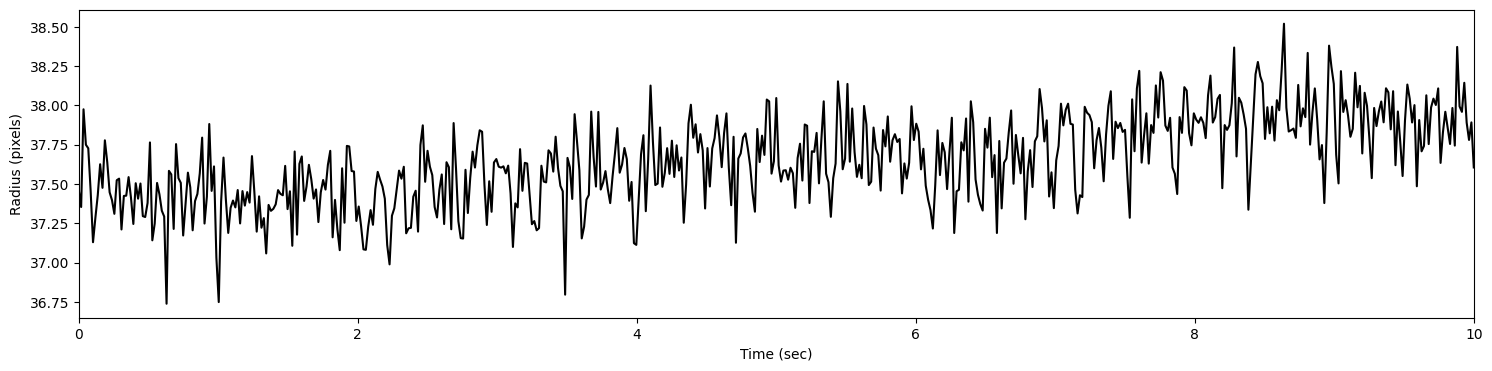

In [25]:
fig, ax = plt.subplots(figsize=(18, 4))
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Radius (pixels)')

ax.plot(t, R_lum_fit[:, 0], ls='-', marker='', c='k')
ax.set_xlim(t[0], t[-1])

Plot center positions as a function of time

(0.0, 10.0)

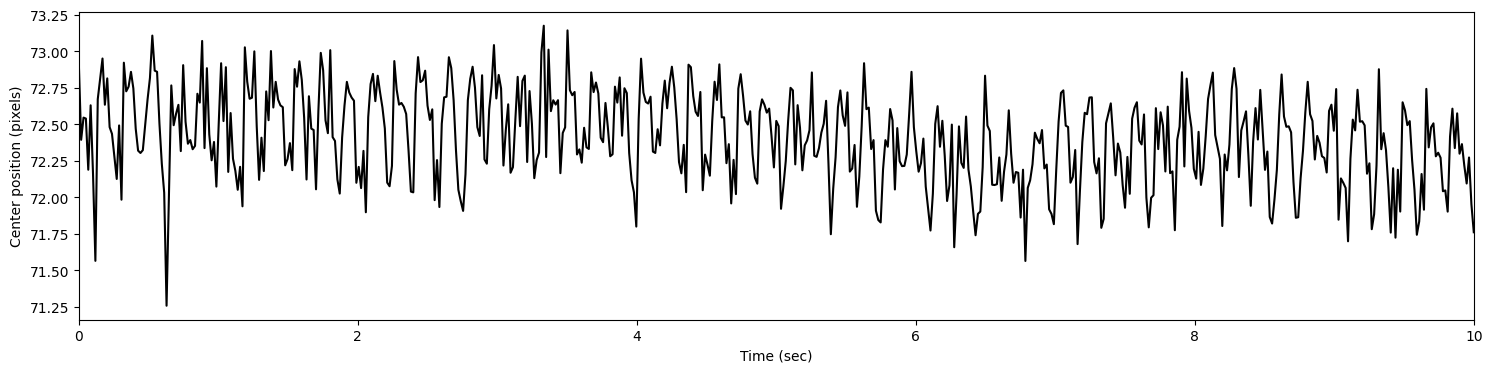

In [26]:
fig, ax = plt.subplots(figsize=(18, 4))
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Center position (pixels)')

ax.plot(t, xc_fit[:, 0], ls='-', marker='', c='k')
ax.set_xlim(t[0], t[-1])

Note the heartbeats (~5-6 Hz) visible in both the radius and center position traces

***

# Inspecting the fits

We selected four fitted profiles and plotted them below
- red curves: Two parts of the fluorescence profile not affected by RBCs. We fit these data.
- blue curve: Full fluorescence profile, including the central part affected by RBCs
- black curve: Fits of the red curves with L_plasma_no_glx (with fixed parameters from the calibration, see above)

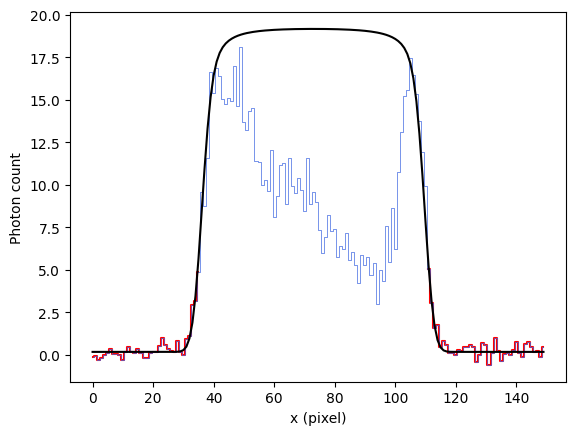

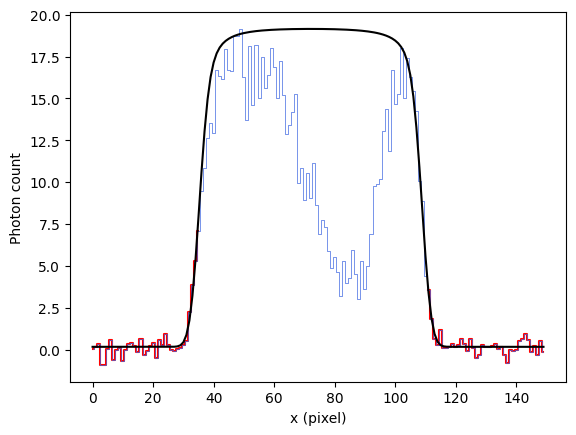

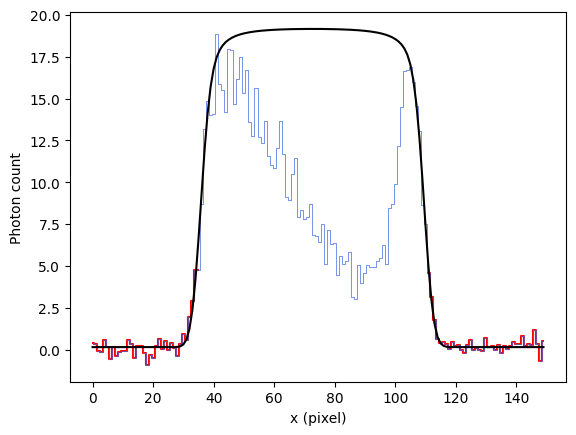

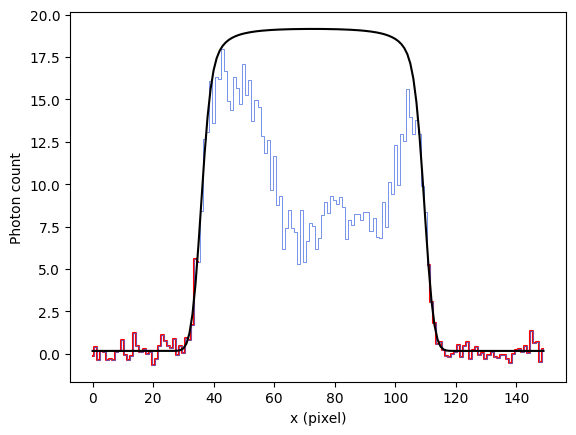

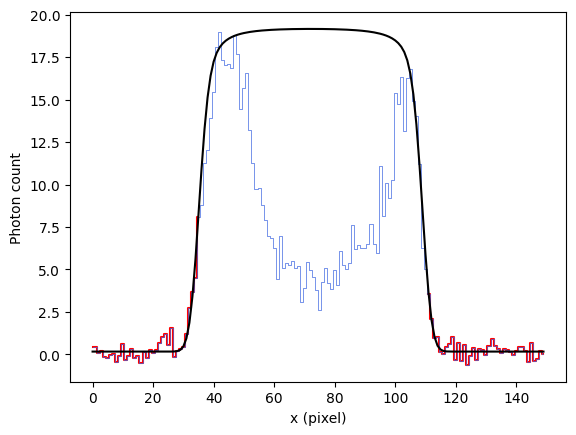

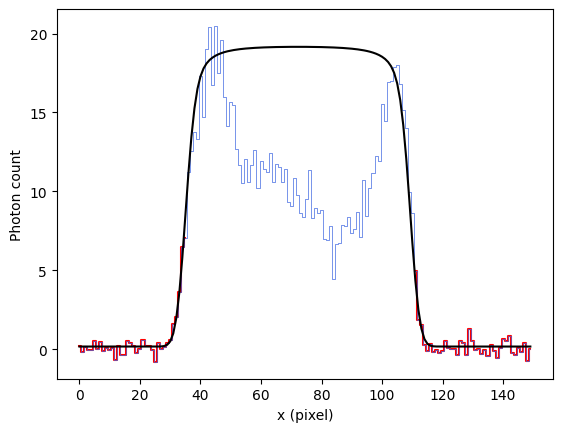

In [27]:
indexes_to_check = np.arange(0, kymogram_blocked_mean.shape[0], 100)

for i in indexes_to_check:
    
    fig, ax = plt.subplots()
    
    ax.set_xlabel('x (pixel)')
    ax.set_ylabel('Photon count')
    
    ax.step(x_edge1, y_edge1[i]/GAIN, c='r', where='mid')
    ax.step(x_edge2, y_edge2[i]/GAIN, c='r', where='mid')
    ax.step(x, kymogram_blocked_mean[i]/GAIN, c='royalblue', lw=0.5, where='mid')

    y_fit_i = L_fit(x, result[i]['xc'][0], result[i]['R_lum'][0])
    ax.plot(x, y_fit_i, c='k')

The fits show consistency with the data, i.e., the black fitted curve goes through the red curves. When this is the case, you can trust the estimates of the radius and capillary center position.